# Import Library

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Import Data

In [3]:
filepath ='/resources/data/Police_Department_Incidents2016.csv'
data = pd.read_csv(filepath)
data.head()
#data.describe()
data.shape


(150500, 14)

# Clean Data by removing non-criminal record

In [4]:
data2 = data[data['Category'] != 'NON-CRIMINAL'] #remove non-crime type incident
data2 = data2[data['Category'] != 'OTHER OFFENSES'] #remove unlabelled crime type incident
data2 = data2[data['Category'] != 'SUSPICIOUS OCC'] #remove unlabelled crime type incident
data2 = data2[data['Category'] != 'MISSING PERSON'] #remove unlabelled crime type incident
data2 = data2[data['Category'] != 'SECONDARY CODES'] #remove unlabelled crime type incident
data2.head()


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,IncidntNum,Category,SeriousCrimeTag,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Longitude,Latitude,Location,PdId
0,120058272,WEAPON LAWS,N,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",1.200000e+13
1,120058272,WEAPON LAWS,N,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",1.200000e+13
2,141059263,WARRANTS,N,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",1.410000e+13
5,160002869,ASSAULT,Y,BATTERY,Friday,01/01/2016 00:00,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",1.600000e+13
8,160003970,WARRANTS,N,WARRANT ARREST,Saturday,01/02/2016 00:00,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)",1.600000e+13


# Explortary Data Analysis

## 1. category of crime sorted

In [5]:
#test code
data3 = data2.iloc[:, 1:4].groupby(['Category', 'SeriousCrimeTag']).count().reset_index()
data4 = data3.sort_values(['Descript'], ascending=False).reset_index()
#data4.columns = ['Category', 'SeriousCrimeTag', 'Count'] + data4.columns[2:].tolist()
#data3['count'] = data2.iloc[:, 1:3].groupby(['Category', 'SeriousCrimeTag'])['Category'].transform('count')
#data3 = data2.iloc[:, 1:3].groupby(['Category'], sort=True).count().reset_index()
data4 =data4.rename(columns = {'Descript':'Count'})

i = data4['Count'].sum(axis = 0, skipna = True)
data4['pct%'] = round(data4['Count']/i*100,1)
data4= data4.drop(['index'], axis =1) 
data4.head(10)

,Category,SeriousCrimeTag,Count,pct%
0,LARCENY/THEFT,N,40409,40.0
1,ASSAULT,Y,13577,13.4
2,VANDALISM,N,8589,8.5
3,VEHICLE THEFT,N,6419,6.4
4,WARRANTS,N,5914,5.9
5,BURGLARY,N,5802,5.7
6,DRUG/NARCOTIC,N,4243,4.2
7,ROBBERY,Y,3299,3.3
8,FRAUD,N,2635,2.6
9,TRESPASS,N,1812,1.8


## 2. Look at crime data by district

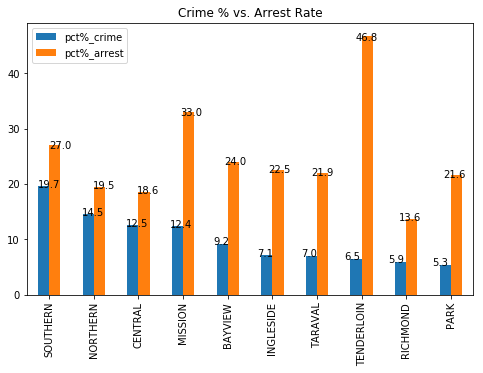

In [8]:

data3 = data2[['PdDistrict', 'Category']].groupby(['PdDistrict']).count().reset_index()
data4 = data3.sort_values(['PdDistrict'], ascending=True)
data4 = data4.rename(columns = {'Category':'Count_crime'})
data4


data7 = data2.groupby('PdDistrict')['Resolution'].apply(lambda x: x[x == 'ARREST, BOOKED'].count())
data7 = data7.rename(columns = {'Resolution':'Count_arrest'})
data7 = pd.DataFrame({'PdDistrict':data7.index, 'Count_arrest':data7.values})
data7

#Let's calcualte the arrest rate on merged table
result2 = pd.merge(data4, data7, on='PdDistrict')
result2 = result2.sort_values(['Count_crime'], ascending=False)

j = result2['Count_crime'].sum(axis = 0, skipna = True)
result2['pct%_crime'] = round(result2['Count_crime']/j*100,1)
result2['pct%_arrest'] = round(result2['Count_arrest']/result2['Count_crime']*100,1)


a = result2.iloc[:,[0, 3, 4]]
a_gf = a.plot(kind='bar', figsize=(8, 5), title = 'Crime % vs. Arrest Rate')
a_gf.set_xticklabels(list(result2['PdDistrict']))

for p in a_gf.patches:
    a_gf.annotate(str(p.get_height()), (p.get_x() * 0.98, p.get_height() * 0.98))
a_gf

## 3. Investigate kidnapping data


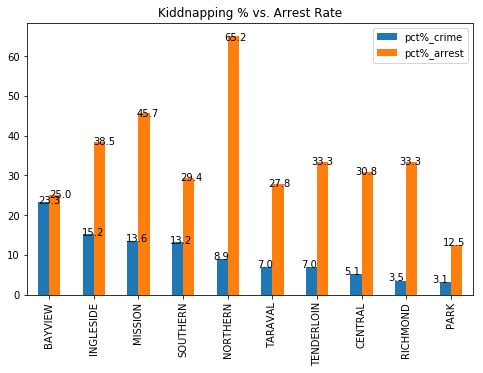

In [7]:
crimedata = data[data['Category'] == 'KIDNAPPING'].reset_index()

#test code group data by district
data3 = crimedata[['PdDistrict', 'Category']].groupby(['PdDistrict']).count().reset_index()
data4 = data3.sort_values(['PdDistrict'], ascending=True)
#data6 =data4.rename(columns = {'Category':'Count'})
data4 = data4.rename(columns = {'Category':'Count_crime'})


#data3 = data2[['PdDistrict', 'Category']].groupby(['PdDistrict']).count().reset_index()
data7 = crimedata.groupby('PdDistrict')['Resolution'].apply(lambda x: x[x == 'ARREST, BOOKED'].count())
data7 = data7.rename(columns = {'Resolution':'Count_arrest'})
#data5 = data5.to_frame(name=None)
data7 = pd.DataFrame({'PdDistrict':data7.index, 'Count_arrest':data7.values})


#Let's calcualte the arrest rate on merged table
result2 = pd.merge(data4, data7, on='PdDistrict')
result2 = result2.sort_values(['Count_crime'], ascending=False)

j = result2['Count_crime'].sum(axis = 0, skipna = True)
result2['pct%_crime'] = round(result2['Count_crime']/j*100,1)
result2['pct%_arrest'] = round(result2['Count_arrest']/result2['Count_crime']*100,1)

#data4= data4.drop(['index'], axis =1) 
#data4.head(10)

a = result2.iloc[:,[0, 3, 4]]
a_gf = a.plot(kind='bar', figsize=(8, 5), title = 'Kiddnapping % vs. Arrest Rate')
a_gf.set_xticklabels(list(result2['PdDistrict']))

for p in a_gf.patches:
    a_gf.annotate(str(p.get_height()), (p.get_x() * 0.98, p.get_height() * 0.98))

# Investigating a particular crime type "Kidnapping"

## Add San Francisco Map

In [9]:
address = 'San Francisco, SF.'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))
map_sanfrancisco = folium.Map(location=[latitude, longitude], zoom_start=15)

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


## Create a crime_mapping function using crime type as input

In [10]:
# create function

def crime_mapping(crimetype): #crimetype is a string
    crimedata = data[data['Category'] == crimetype]
    
    for lat, lng, district, address in zip(crimedata['Latitude'], crimedata['Longitude'], crimedata['PdDistrict'], crimedata['Address']):
        label = '{}, {}'.format(district, address)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sanfrancisco)  
    
    return map_sanfrancisco

In [11]:
#test function
crime_mapping('KIDNAPPING')

# Get FourSquare Location Venue Information

In [14]:
#load foursquare login
CLIENT_ID = 'SPJ2UUQPO1THAUAWDC2UOSEIY4YKNBDLXYHELMKQT5QGL0DF' # your Foursquare ID
CLIENT_SECRET = '2C3SEFCT1QOLFNLGMAXQUMRRXKZM44LVT50NRVOTFJ02M5CB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: SPJ2UUQPO1THAUAWDC2UOSEIY4YKNBDLXYHELMKQT5QGL0DF
CLIENT_SECRET:2C3SEFCT1QOLFNLGMAXQUMRRXKZM44LVT50NRVOTFJ02M5CB


In [156]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            50) #Limit
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# need to change code

crime_venues = getNearbyVenues(names=crimedata_test['Neighbourhood'],
                                   latitudes=crimedata_test['Latitude'],
                                   longitudes=crimedata_test['Longitude']
                                  )
print(crime_venues.shape)
crime_venues.head()
crime_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(crime_venues['Venue Category'].unique())))   hiding this to save time

In [ ]:
## Get venue frequency data for location 

In [ ]:
crime_onehot = pd.get_dummies(crime_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
crime_onehot['Neighborhood'] = crime_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [crime_onehot.columns[-1]] + list(crime_onehot.columns[:-1])
crime_onehot = crime_onehot[fixed_columns]

crime_onehot.shape
crime_grouped = crime_onehot.groupby('Neighborhood').mean().reset_index()
crime_grouped.shape

num_top_venues = 5

for hood in crime_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = crime_grouped[crime_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
 # comment in order to avoid having speed up
  #  print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))  
  #  print('\n')

In [ ]:
## Create new dataframe with top 10 venue inforation per location

In [160]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = crime_grouped['Neighborhood']

for ind in np.arange(crime_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(crime_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
#i noticed a problem here, my cluster information doesn't have crime frequency, but perhaps i can set feature clustering then compare where the common feature are 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BAYVIEW / 0 Block of BERTHA LN,Park,Bookstore,Art Gallery,Zoo,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop
1,BAYVIEW / 0 Block of BRIDGEVIEW DR,Southern / Soul Food Restaurant,Light Rail Station,Fried Chicken Joint,Bakery,Theater,BBQ Joint,Park,Market,Grocery Store,African Restaurant
2,BAYVIEW / 0 Block of CASHMERE ST,Park,Restaurant,Brewery,Bookstore,Non-Profit,Skate Park,Falafel Restaurant,English Restaurant,Ethiopian Restaurant,Event Space
3,BAYVIEW / 0 Block of COMMER CT,Park,Gym,Zoo,Farm,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor
4,BAYVIEW / 0 Block of GEORGE CT,Bus Station,Park,Brewery,Zoo,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant


In [163]:
crime_merged = crimedata_test
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
crime_merged = crime_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
crime_merged.dropna(axis=0, inplace=True)
crime_merged.head()


,PdDistrict,Latitude,Longitude,Neighbourhood,DayOfWeek,Hour,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,INGLESIDE,37.712200,-122.420864,INGLESIDE / 100 Block of BROOKDALE AV,Friday,08,Pool,Playground,Basketball Court,Bike Trail,Mexican Restaurant,Zoo,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit
1,SOUTHERN,37.784189,-122.407634,SOUTHERN / 800 Block of MARKET ST,Friday,16,Women's Store,Coffee Shop,Clothing Store,Toy / Game Store,Cosmetics Shop,Food Truck,Thai Restaurant,Marijuana Dispensary,Bubble Tea Shop,Department Store
2,INGLESIDE,37.723986,-122.435408,INGLESIDE / 4600 Block of MISSION ST,Friday,23,Chinese Restaurant,Mexican Restaurant,Bakery,Latin American Restaurant,Liquor Store,Grocery Store,Sandwich Place,Vietnamese Restaurant,Japanese Restaurant,Pharmacy
3,BAYVIEW,37.719033,-122.398004,BAYVIEW / 1000 Block of LECONTE AV,Saturday,12,Breakfast Spot,Historic Site,Mountain,Burger Joint,Park,Bike Rental / Bike Share,Martial Arts Dojo,Farm,Event Space,Exhibit
4,BAYVIEW,37.729203,-122.374019,BAYVIEW / 700 Block of KIRKWOOD AV,Saturday,18,Harbor / Marina,Construction & Landscaping,Spa,Business Service,Zoo,Farm,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit


# K-mean clustering

In [ ]:
# create new matrix with location data
# set number of clusters
kclusters = 5

crime_grouped_clustering = crime_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(crime_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

crime_merged = crimedata_test
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
crime_merged = crime_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
crime_merged.dropna(axis=0, inplace=True)
crime_merged

In [174]:
crime_merged.head()
crime_merged.to_csv('crime_merged.csv', index=False)

# Create cluster map

In [166]:
## Apply Clusetering Analysis
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]# add markers to the map

markers_colors = []
for lat, lon, poi, cluster in zip(crime_merged['Latitude'], crime_merged['Longitude'], crime_merged['Neighbourhood'], crime_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# Optional saving crime_merged.csv for offline work

In [46]:
crime_merged = pd.read_csv('crime_merged.csv')
crime_merged.head()

,PdDistrict,Latitude,Longitude,Neighbourhood,DayOfWeek,Hour,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,INGLESIDE,37.712200,-122.420864,INGLESIDE / 100 Block of BROOKDALE AV,Friday,8,4,Pool,Playground,Basketball Court,Bike Trail,Mexican Restaurant,Zoo,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit
1,SOUTHERN,37.784189,-122.407634,SOUTHERN / 800 Block of MARKET ST,Friday,16,2,Women's Store,Coffee Shop,Clothing Store,Toy / Game Store,Cosmetics Shop,Food Truck,Thai Restaurant,Marijuana Dispensary,Bubble Tea Shop,Department Store
2,INGLESIDE,37.723986,-122.435408,INGLESIDE / 4600 Block of MISSION ST,Friday,23,2,Chinese Restaurant,Mexican Restaurant,Bakery,Latin American Restaurant,Liquor Store,Grocery Store,Sandwich Place,Vietnamese Restaurant,Japanese Restaurant,Pharmacy
3,BAYVIEW,37.719033,-122.398004,BAYVIEW / 1000 Block of LECONTE AV,Saturday,12,3,Breakfast Spot,Historic Site,Mountain,Burger Joint,Park,Bike Rental / Bike Share,Martial Arts Dojo,Farm,Event Space,Exhibit
4,BAYVIEW,37.729203,-122.374019,BAYVIEW / 700 Block of KIRKWOOD AV,Saturday,18,3,Harbor / Marina,Construction & Landscaping,Spa,Business Service,Zoo,Farm,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit


In [50]:
cluster1 = crime_merged.loc[crime_merged['Cluster Labels'] == 0, crime_merged.columns[[0] + list(range(4, crime_merged.shape[1]))]]
cluster1.to_csv('cluster1.csv', index=False)
cluster1.shape

(14, 14)

In [51]:
cluster2 = crime_merged.loc[crime_merged['Cluster Labels'] == 1, crime_merged.columns[[0] + list(range(4, crime_merged.shape[1]))]]
cluster2.to_csv('cluster2.csv', index=False)
cluster2.shape

(13, 14)

In [52]:
cluster3 = crime_merged.loc[crime_merged['Cluster Labels'] == 2, crime_merged.columns[[0] + list(range(4, crime_merged.shape[1]))]]
cluster3.to_csv('cluster3.csv', index=False)
cluster3.shape

(167, 14)

In [54]:
cluster4 = crime_merged.loc[crime_merged['Cluster Labels'] == 3, crime_merged.columns[[0] + list(range(4, crime_merged.shape[1]))]]
cluster4.to_csv('cluster4.csv', index=False)
cluster4.shape

(58, 14)

In [55]:
cluster5 = crime_merged.loc[crime_merged['Cluster Labels'] == 4, crime_merged.columns[[0] + list(range(4, crime_merged.shape[1]))]]
cluster5.to_csv('cluster5.csv', index=False)
cluster5.shape

(5, 14)

# Cluster 4 analysis  

[Text(0, 0, 'Park'),
 Text(0, 0, 'Light Rail Station'),
 Text(0, 0, 'Southern / Soul Food Restaurant'),
 Text(0, 0, 'Playground'),
 Text(0, 0, 'Mountain'),
 Text(0, 0, 'Grocery Store'),
 Text(0, 0, 'Rental Car Location'),
 Text(0, 0, 'Intersection'),
 Text(0, 0, 'Brewery')]

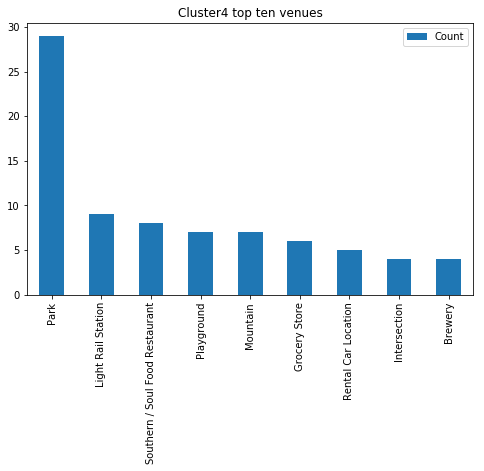

In [32]:
# mark the most common venue by cluster 
a = cluster4['1st Most Common Venue']
b = cluster4['2nd Most Common Venue']
c = cluster4['3rd Most Common Venue']
frames = [a, b, c]
cluster_feature_vector = pd.concat(frames)
cluster_feature_vector = pd.DataFrame({'venue':cluster_feature_vector.values, 'Count':cluster_feature_vector.index})
cluster_feature_vector.shape
cluster_feature_vector = cluster_feature_vector.groupby(['venue'])['Count'].count().reset_index()
cluster_feature_vector = cluster_feature_vector.sort_values(['Count'], ascending=False)
cluster_feature_vector.head(10)
d_gf = cluster_feature_vector.iloc[0:9,:].plot(kind='bar', figsize=(8, 5), title = 'Cluster4 top ten venues')
d_gf.set_xticklabels(list(cluster_feature_vector['venue']))

#now take a look at weekday time

temp = cluster4.groupby('DayOfWeek').count().reset_index()
temp2 = cluster4.groupby('Hour').count().reset_index()

# creating dataframe y using weekday as group

#y.set_xticklabels(y['DayOfWeek'])
y = temp.iloc[:, 0:2]
y = y.rename(columns = {'PdDistrict':'Count'})
y = y.sort_values(['Count'], ascending=False)
e_gf=y.plot(kind='bar', figsize=(8, 5), title ='Cluster4 incident by weekday', width=0.2)
e_gf.set_xticklabels(list(y['DayOfWeek']))

# creating dataframe x using Hour as group
x = temp2.iloc[:, 0:2]
x = x.rename(columns = {'PdDistrict':'Count'})
#x = x.sort_values(['Count'], ascending=False)
f_gf=x['Count'].plot(kind='bar', figsize=(8, 5), title ='Cluster4 incident by hour', width=0.2)
f_gf.set_xticklabels(list(x['Hour']))


# Cluster 3 analysis



In [ ]:
# mark the most common venue by cluster 
a = cluster3['1st Most Common Venue']
b = cluster3['2nd Most Common Venue']
c = cluster3['3rd Most Common Venue']
frames = [a, b, c]
cluster_feature_vector = pd.concat(frames)
cluster_feature_vector = pd.DataFrame({'venue':cluster_feature_vector.values, 'Count':cluster_feature_vector.index})
cluster_feature_vector.shape
cluster_feature_vector = cluster_feature_vector.groupby(['venue'])['Count'].count().reset_index()
cluster_feature_vector = cluster_feature_vector.sort_values(['Count'], ascending=False)
cluster_feature_vector.head(10)
d_gf = cluster_feature_vector.iloc[0:9,:].plot(kind='bar', figsize=(8, 5), title = 'Cluster3 top ten venues')
d_gf.set_xticklabels(list(cluster_feature_vector['venue']))

#now take a look at weekday time

temp = cluster3.groupby('DayOfWeek').count().reset_index()
temp2 = cluster3.groupby('Hour').count().reset_index()

# creating dataframe y using weekday as group

#y.set_xticklabels(y['DayOfWeek'])
y = temp.iloc[:, 0:2]
y = y.rename(columns = {'PdDistrict':'Count'})
y = y.sort_values(['Count'], ascending=False)
e_gf=y.plot(kind='bar', figsize=(8, 5), title ='Cluster3 incident by weekday', width=0.2)
e_gf.set_xticklabels(list(y['DayOfWeek']))

# creating dataframe x using Hour as group
x = temp2.iloc[:, 0:2]
x = x.rename(columns = {'PdDistrict':'Count'})
#x = x.sort_values(['Count'], ascending=False)
f_gf=x['Count'].plot(kind='bar', figsize=(8, 5), title ='Cluster3 incident by hour', width=0.2)
f_gf.set_xticklabels(list(x['Hour']))


[Text(0, 0, 'Monday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Wednesday')]

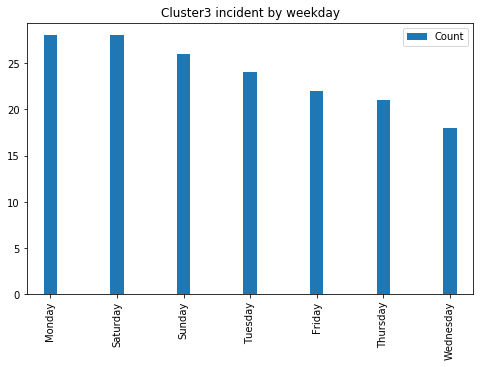

In [80]:

#y.set_xticklabels(y['DayOfWeek'])
y = temp.iloc[:, 0:2]
y = y.rename(columns = {'PdDistrict':'Count'})
y = y.sort_values(['Count'], ascending=False)
e_gf=y.plot(kind='bar', figsize=(8, 5), title ='Cluster3 incident by weekday', width=0.2)
e_gf.set_xticklabels(list(y['DayOfWeek']))


[Text(0, 0, 'BAYVIEW'),
 Text(0, 0, 'INGLESIDE'),
 Text(0, 0, 'MISSION'),
 Text(0, 0, 'NORTHERN'),
 Text(0, 0, 'PARK'),
 Text(0, 0, 'RICHMOND'),
 Text(0, 0, 'SOUTHERN'),
 Text(0, 0, 'TARAVAL')]

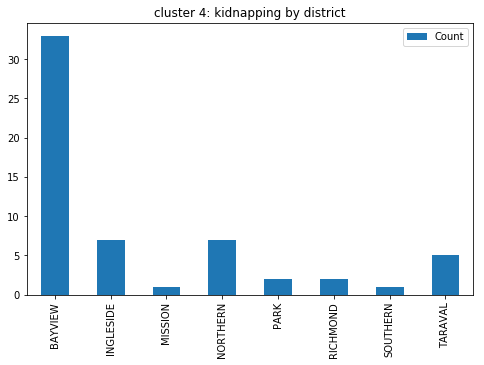

In [96]:
# use the same code for cluster 3 and 4
hello = cluster4[['PdDistrict', 'Cluster Labels']].groupby('PdDistrict')['Cluster Labels'].count().reset_index(name = 'Count')
g_gf = hello.plot(kind='bar', figsize=(8, 5), title = 'cluster 4: kidnapping by district')
g_gf.set_xticklabels(list(hello['PdDistrict']))